# Test SEM and npSEM algorithms on a 3d-Lorenz state-space model
Consider a Lorenz-63  model
\begin{equation} 
X_t =  m(X_{t-1}) +  \eta_t, \quad \eta_t \sim \mathcal{N} \left( 0, Q\right),\\
Y_t =   H_tX_t +  \epsilon _t, \quad   \epsilon _t \sim \mathcal{N} \left( 0, R\right).
\end{equation}

The dynamical model $m$ is defined by the following differential equation
\begin{equation} 
z(0) = x, \\
\frac{dz(\tau)}{d\tau} = g(z(\tau)), \quad   \tau  \in [0,dt], \\
m(x) = z(dt),
\end{equation}
where $g(z)  =\left(10(z_2-z_1), ~ z_1(28-z_3) -z_2,~  z_1z_2 - 8/3 z_3 \right)$, $~ \forall z=(z_1,z_2,z_3)^\top \in \mathbb{R}^3$.  

Given true error covariances  $(Q^*,R^*)= (\sigma _Q^{2,*}I_3, \sigma _{R}^{2,*} I_{3})=(I_3, 4I_{3})$, where $I_3$ denotes the identity matrices with dimension $3$ , sequences of the state process $(X_t)$ and the observations process $(Y_t)$ with length $T$ are simulated.

The npSEM algorithms are run to reconstruct the model $m(x)$ and estimate the parameter $\theta = (\sigma _{Q}^{2}, \sigma _{R}^{2}) \in \mathbb{R} \times \mathbb{R}$ given the observed sequence. Its results are compared to the ones derived from SEM algorithms, SEM($\mathfrak{M}$), where (1) both the true model ($\mathfrak{M}=m$) and the observations are provided, and (2) both an estimate ($\mathfrak{M} = \widehat m$) of $m$ learned on a sequence of the state process and the observations are provided. In addition, the performance of the SEM and npSEM algorithms combined with different smoothing schemes (EnKS: Ensemble Kalman Smoother, CPF-BS: Conditioning Particle Filtering-Backward Simulation) is shown. Notations of these algorithms are below:

- 'CPF-BS update' corresponds to the npSEM algorithm.
- 'CPF-BS no update' corresponds to the npSEM algorithm where the 'catalog update' step in not performed. In this algorithm, only the value of the parameter $\theta$ is updated at each iteration  but the non-parametric estimate of $m$ is not updated. Hence it also corresponds to  the SEM($\mathfrak{M}$) algorithm with $\mathfrak{M}$ obtained using LLR on the observed sequence $y_{1:T}$. 
- 'CPF-BS perfect' corresponds to  the SEM($\mathfrak{M}$) algorithm with $\mathfrak{M}$ obtained using LLR on a perfect sequence. Remark that in order to run this algorithm, a realization of the true state $x_{1:T}$ ('perfect catalog') needs to be available, which is generally not the case for real applications.
- 'CPF-BS true $m$' corresponds to  the SEM($\mathfrak{M}$) algorithm with $\mathfrak{M}=m$. 
- 'EnKS update', 'EnKS no update', 'EnKS perfect' and 'EnKS true $m$' are the same algorithms as defined above except that the smoother used in the E-step is the EnKS instead of the CPF-BS.


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
### IMPORT PACKAGES
import os
import copy
import numpy as np
from scipy.stats import multivariate_normal
from tqdm import tqdm
from time import clock
from tempfile import TemporaryFile
from multiprocessing import Pool
from pykalman import KalmanFilter
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import cm

#import L63 models
import models.l63f as mdl_l63
from models.L63 import l63_predict, l63_jac
#import routines
from methods.generate_data import generate_data
from methods.LLR_forecasting_CV import m_LLR
from methods.model_forecasting import m_true
from methods.k_choice import k_choice
from methods.CPF_BS_smoothing import _CPF_BS
from methods.SEM import CPF_BS_SEM
from methods.npSEM import LLR_CPF_BS_SEM
from methods.EnKS import _EnKS
from methods.EnKS_EM import EnKS_EM
from methods.EnKS_npEM import LLR_EnKS_EM
from methods.additives import RMSE


In [3]:
#%% DEFINITIONS
class test_class:
    def __init__(self,X,Y, Z,Xcond_test, time, Nf, Ns, num_iter):
        self.decision = True
        self.X = X
        self.Y = Y
        self.Z = Z
        self.init = 'KS' #'KS' or 'none'        
        self.Xcond = Xcond_test
        self.time = time
        self.Nf = Nf
        self.Ns = Ns
        self.num_iter = num_iter
class distribution_class:
    def __init__(self,distribution_name,parameters):
        self.dist = distribution_name
        self.pars = parameters
        
   
class Catalog:
    def __init__(self, data=np.zeros((1,1)), time = np.array([0])):
        self.dx = data.shape[0]
        self.T = data.shape[-1] 
#         self.Nb = data.shape[2] #number of sequences in the given batches 

        self.ana = data[...,:-1]
        self.suc = data[...,1:]
        self.time = time[:-1] 

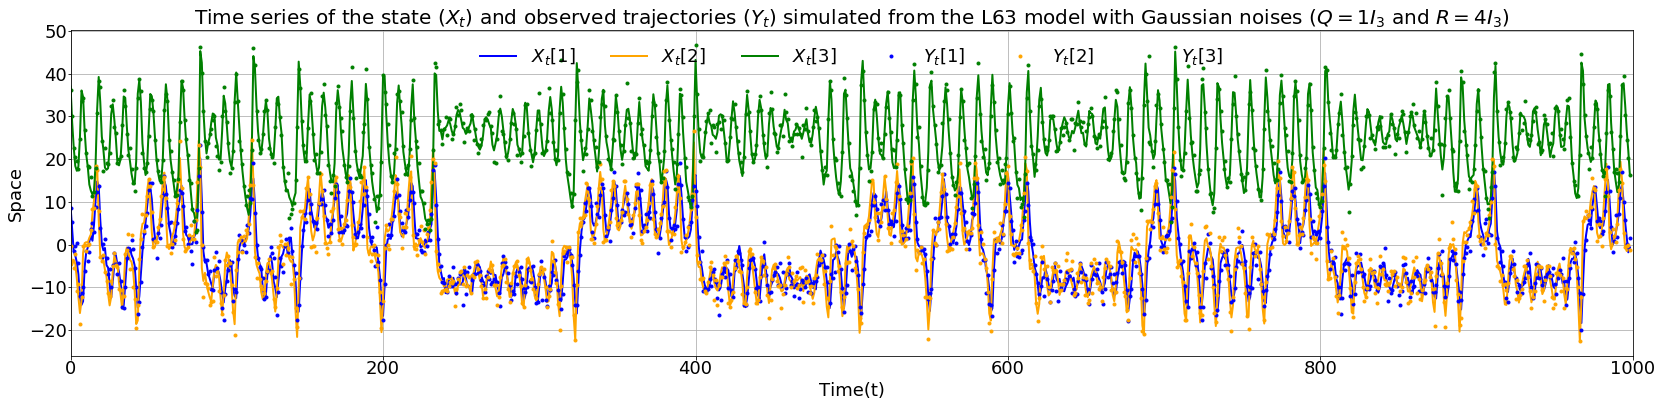

In [4]:
#%% GENERATE DATA

num_seed = 1 # chosen for testing simulated timeseries with different values of random seed 
T=1000 # length of the training
# parameters
dx = 3 # dimension of the state
dt_int = 0.01 # fixed integration time
dt_model = 8 # chosen number of model time step  \in [1, 25]-the larger dt_model the more nonliner model
var_obs = np.array([0,1,2]) # indices of the observed variables
dy = len(var_obs) # dimension of the observations
H_true = np.eye(dx)
h = lambda x: H_true.dot(x)  # observation model


sigma = 10.0; rho = 28.0; beta = 8.0/3 # physical parameters
fmdl=mdl_l63.M(sigma=sigma, rho=rho, beta=beta, dtcy= dt_int)
mx = lambda x: fmdl.integ(x) # fortran version (fast)
jac_mx = lambda x: l63_jac(x, dt_int*dt_model, sigma, rho, beta) # python version (slow)

# setting covariances
sig2_Q = 1; sig2_R = 4 # parameters
Q_true = np.eye(dx) *sig2_Q # model covariance
R_true = np.eye(dx) *sig2_R # observation covariance
mod_info = distribution_class('Gaussian',parameters = np.nan) #chosen in {'Gaussian', 'Student-t',...}; if  'Student-t', choose parameters = dof
obs_info = distribution_class('Gaussian',parameters = np.nan) #chosen in {'Gaussian', 'Student-t',...}; if  'Student-t', choose parameters = dof
# prior state
x0 = np.r_[8, 0, 30]

# generate data
T_burnin = 5*10**3 #length of the burn-in phase
T_train = T# length of the training
T_test = 10**3 # length of the testing data
# num_seed = 1

X_train, Y_train, X_test, Y_test, y0 = generate_data(x0,mx,h,Q_true,R_true,dt_int,dt_model,var_obs, T_burnin, T_train, T_test, num_seed, mod_info, obs_info) 
X_train.time = np.arange(0,T_train)
Y_train.time= X_train.time[1:]
X_test.time = np.arange(0,T_test)
Y_test.time= X_test.time[1:]

# for only SSMs with covariates of the state X
Z = np.nan*X_train.values.copy()
Z_perfect = np.nan*X_train.values.copy()
Z_test = np.nan*X_test.values.copy()
missing_data = False

X_train0, Y_train0, _, _, _ = generate_data(X_test.values[:,-1],mx,h,Q_true,R_true,dt_int,dt_model,var_obs, T_burnin, T_train, T_test, num_seed, mod_info, obs_info)   
X_train0.time = np.arange(0,T_train)

### PLOT STATE, OBSERVATIONS AND CATALOG

FS = 20; FS1 =18; LW= 2; MS = 6; LP = -0.1
plt.rcParams['figure.figsize'] = (28,6)
plt.rcParams['xtick.major.pad']='0'
plt.rcParams['ytick.major.pad']='0'
plt.rc('xtick', labelsize= FS1) 
plt.rc('ytick', labelsize= FS1)
plt.figure()
plt.plot(X_train.values[0,1:].T,'-',c='b',linewidth = LW, label = '$X_t[1]$')
plt.plot(X_train.values[1,1:].T,'-',c='orange',linewidth = LW, label = '$X_t[2]$')
plt.plot(X_train.values[2,1:].T,'-',c='g',linewidth = LW, label = '$X_t[3]$')
plt.plot(Y_train.values[0,:].T,'.',c='b', markersize=MS, label = '$Y_t[1]$')
plt.plot(Y_train.values[1,:].T,'.',c='orange', markersize=MS, label = '$Y_t[2]$')
plt.plot(Y_train.values[2,:].T,'.',c='g', markersize=MS, label = '$Y_t[3]$')
plt.legend(frameon =False,loc = 'best', ncol=6, fontsize =FS1)
plt.xlim([0,1000])
plt.xlabel('Time(t)', fontsize =FS1)
plt.ylabel('Space', fontsize =FS1)
plt.title('Time series of the state ($X_t$) and observed trajectories ($Y_t$) simulated from the L63 model with Gaussian noises ($Q=$'+str(sig2_Q)+'$I_3$ and $R=$'+str(sig2_R)+'$I_3$)', fontsize =FS)
plt.grid()
plt.show()


In [5]:
#%% SETTINGs for SEM and npSEM algorithms
class estQ:
    value = Q_true;
    type = 'fixed' # chosen predefined type of model error covatiance ('fixed', 'adaptive')
    form = 'constant' # chosen esimated matrix form ('full', 'diag', 'constant')
    base =  np.eye(dx) # for fixed base of model covariance (for 'constant' matrix form only)
    decision = True # chosen if Q is estimated or not ('True', 'False')
class estR:
    value = R_true;
    type = 'fixed' # chosen predefined type of observation error covatiance ('fixed', 'adaptive')
    form = 'constant' # chosen esimated matrix form ('full', 'diag', 'constant')
    base =  np.eye(dx) # for fixed base of model covariance
    decision = True # chosen if R is estimated or not ('True', 'False')
class estX0:
    decision = False # chosen if X0 is estimated or not ('True', 'False')

class estD: # for non-parametric approach only
    decision = True # chosen if the smoothed data is updated or not ('True', 'False')
## true_FORECASTING (dynamical model)
m = lambda x,pos_x,ind_x,Q: m_true(x,pos_x,ind_x, Q, mx,jac_mx, dt_model)

class LLR_class:
    def __init__(self,catalog,Z=np.nan, Zx = np.nan) :
        self.data = catalog
        self.data_prev = None
        self.lag_x = 5 # lag of removed analogs around x to avoid an over-fitting forecast
        self.lag_Dx = lambda x: np.shape(x)[-1] # lag of moving window of analogs chosen around x 
        self.time_period = 1# set 365.25 for year (real data only) and 1 as default
        self.k_m = 100 # number of analogs 
        self.k_Q = 100 # number of analogs 
        self.estK = 'same' # set 'same' if k_m = k_Q chosen, otherwise, set 'different'
        self.kernel = 'tricube'# set 'rectangular' or 'tricube'
        self.nN_m =  tab_nb_analogs #number of analogs to be chosen for mean estimation
        self.nN_Q =  tab_nb_analogs #number of analogs to be chosen for dynamical error covariance
        self.estK_decision = False
        self.lag_k = 1; #chosen the lag for k reestimation 
        self.k_lag = 20;
        self.k_inc = 10
        self.Q = estQ 
        self.gam = 1
        T, dz = Z.shape[0], Z.shape[1]
        self.Zfit = False ## Choose False if Z is used to search the analogs only
        if len(Z.shape)>2:
            self.Z = Z[:,:,0].T
            self.Zx = Zx[:,:,0].T
            for j in range(1,Z.shape[2]):
                self.Z = np.concatenate((self.Z,Z[:,:,j].T),axis=0)
                self.Zx= np.concatenate((self.x,Zx[:,:,j].T),axis=0)
        else:
            self.Z = Z
            self.Zx = Zx
            
Nf, Ns, Ne, N_iter = 10, 5, 20, 50 #  number of particles,number of realizations, number of members (for EnKS) and  number of iterations used in the TRAINING phase of  the SEM and npSEM algorithms
Nf_test, Ns_test, num_iter_test =  Nf, Ns, 20 #  number of particles,number of realizations, number of members (for EnKS) and  number of iterations used in the TESTING phase of  the SEM and npSEM algorithms

gam1 = np.ones(N_iter,dtype=int)  #for SEM (stochastic EM)
gam2 = np.ones(N_iter, dtype=int)
for k in range(50,N_iter):
    gam2[k] = k**(-0.7) # for SAEM (stochastic approximation EM)


# Values of k nearest neighbors for a grid search
tab_nb_analogs_all = np.arange(10*dx,T,20)
tab_nb_analogs = tab_nb_analogs_all[np.where(tab_nb_analogs_all<min(300,T))[0]]
# Catalogs 
catalog =  Catalog(data=Y_train.values.reshape(dx,1,T-1),time=np.arange(1,T,dtype=int)) 
Ctrain = Catalog(data=Y_train.values.reshape(dx,1,T-1),time=np.arange(1,T,dtype=int)) 
Ctrain_perfect = Catalog(data=X_train0.values.reshape(dx,1,T),time=np.arange(0,T,dtype=int)) 

In [6]:
# EM-KS as initilization for the SEM and npSEM algorithms    
kf = KalmanFilter(observation_matrices = np.eye(dy))
measurements = Y_train.values.T 
kf = kf.em(measurements, n_iter=100,  em_vars=["transition_matrices","transition_offsets","observation_covariance","transition_covariance"])
Xks, Xks_cov = np.nan*X_test.values.T.copy(), np.nan*np.zeros([T_test,dx,dx])
if missing_data==False:
    (smoothed_state_means, smoothed_state_covariances) = kf.smooth(Y_test.values.T)
else:
    meas = np.ma.masked_array(Y_test.values.T, mask = np.isnan(Y_train.values.T))
    (smoothed_state_means, smoothed_state_covariances) = kf.smooth(meas)

# Prior state, initial parameters
B = np.eye(dx)*1.0 #*np.eye(dx)
xb = X_train.values[:,0]#np.zeros([dx])#np.squeeze(e(np.zeros((dx,1)))
R_init0 = np.trace(kf.observation_covariance)*np.eye(dy)/dy ### Reset to Z?
Q_init0 = np.trace(kf.transition_covariance)*np.eye(dx)/dx
# Initial conditioning trajectories for the algorithms coupled with CPF-BS
Xcond_test = Y_test.values.copy() #if test.init =KS (run inside)
time_test = X_test.time
test = test_class(X_test.values,Y_test.values, Z_test,Xcond_test, time_test, Nf_test, Ns_test, num_iter_test)


In [7]:
# RUNNING SEM and npSEM algorithms
print("0. EnKS - true m")
out_EnKS_EM_m = EnKS_EM(Y_train.values,X_train.values,m,Q_init0,\
                        H_true,R_init0,xb,B ,dx, Ne,1,np.arange(T),\
                        N_iter,np.ones(N_iter,dtype=int),estQ,estR,estX0,test)
Q_SEM_ENKS_m = out_EnKS_EM_m['EM_state_error_covariance'] 
R_SEM_ENKS_m = out_EnKS_EM_m['EM_observation_error_covariance'] 
Xs_SEM_ENKS_m = out_EnKS_EM_m['smoothed_samples']  
Xs_test_SEM_ENKS_m = out_EnKS_EM_m['smoothed_test_samples']       

print("1. EnKS fixed catalog - perfect")
LLR_perfect = LLR_class(Ctrain_perfect,Z_perfect,Z)
class estD: # for non-parametric approach only
    decision = False # chosen if the smoothed data is updated or not ('True', 'False')
LLR_perfect.Q.value = Q_init0
time_perf = np.arange(LLR_perfect.data.ana.shape[-1])
LLR_perfect.nN_m, LLR_perfect.nN_Q  = tab_nb_analogs,tab_nb_analogs    
k_fixe_opt_perf, _= k_choice(LLR_perfect,LLR_perfect.data.ana,LLR_perfect.data.suc, time_perf) # choose an optimal number of neighbors used in LLR forecast
k_m, k_Q = k_fixe_opt_perf, k_fixe_opt_perf
LLR_perfect.k_m = k_m; LLR_perfect.k_Q = k_Q; 
LLR_perfect.lag_x = 0
m_hat = lambda  x,pos_x,ind_x: m_LLR(x,pos_x,ind_x,LLR_perfect) # LLR forecast model
# run EnKS 
out_EnKS_EM_hat_perfect = LLR_EnKS_EM(Y_train.values,X_train.values,LLR_perfect,\
                                      H_true,R_init0,\
                                      xb,B ,dx, Ne,1,np.arange(T),\
                                      N_iter,np.ones(N_iter,dtype=int),estD,estQ,estR,estX0,test)
Q_SEM_ENKS_perfect = out_EnKS_EM_hat_perfect['EM_state_error_covariance'] 
R_SEM_ENKS_perfect = out_EnKS_EM_hat_perfect['EM_observation_error_covariance'] 
Xs_SEM_ENKS_perfect = out_EnKS_EM_hat_perfect['smoothed_samples']  
Xs_test_SEM_ENKS_perfect = out_EnKS_EM_hat_perfect['smoothed_test_samples']   

print("2. EnKS fixed catalog - observation")
class estD: # for non-parametric approach only
    decision = False # chosen if the smoothed data is updated or not ('True', 'False')
LLR_init = LLR_class(Ctrain,Z, Z) 
LLR_init.Q.value = Q_init0
LLR_init.data.time = np.arange(1,LLR_init.data.ana.shape[-1]+1)
time_noisy = np.arange(1,LLR_init.data.ana.shape[-1]+1)
LLR_init.nN_m, LLR_init.nN_Q  = tab_nb_analogs,tab_nb_analogs    
k_fixe_opt_noisy, _= k_choice(LLR_init,LLR_init.data.ana,LLR_init.data.suc, time_noisy) # choose an optimal number of neighbors used in LLR forecast        
k_m, k_Q = k_fixe_opt_noisy, k_fixe_opt_noisy 
LLR_init.k_m = k_m; LLR_init.k_Q = k_Q; 
m_hat = lambda  x,pos_x,ind_x: m_LLR(x,pos_x,ind_x,LLR_init) # LLR forecast model
# run EnKS
out_EnKS_EM_hat = LLR_EnKS_EM(Y_train.values,X_train.values,LLR_init,\
                              H_true,R_init0,xb,B ,dx, Ne,1,np.arange(T),\
                              N_iter,np.ones(N_iter,dtype=int),estD,estQ,estR,estX0,test)
Q_SEM_ENKS = out_EnKS_EM_hat['EM_state_error_covariance'] 
R_SEM_ENKS = out_EnKS_EM_hat['EM_observation_error_covariance'] 
Xs_SEM_ENKS = out_EnKS_EM_hat['smoothed_samples']  
Xs_test_SEM_ENKS = out_EnKS_EM_hat['smoothed_test_samples']  

print("3. SEM-EnKS - with catalog update")
Y_smooth = smoothed_state_means.ravel()
catalog =   Catalog(data=Y_smooth.reshape(dx,1,T-1),time=np.arange(1,T))

k_update = True
estD.decision = True  # on met à jour le catalogue toutes les 5 iterations 
LLR =  LLR_class(catalog,Z, Z) #[1:,...]
LLR.Q.value = Q_init0
LLR.data.time = np.arange(1,LLR.data.ana.shape[-1]+1)
time_noisy = np.arange(1,LLR.data.ana.shape[-1]+1)            
LLR.estK_decision = k_update
LLR.nN_m, LLR.nN_Q  = tab_nb_analogs,tab_nb_analogs    
k_fixe_opt_KS, _= k_choice(LLR,LLR.data.ana,LLR.data.suc, time_noisy) # choose an optimal         
k_m, k_Q = k_fixe_opt_KS, k_fixe_opt_KS # choose an optimal number of neighbors used in LLR forecast?
LLR.k_m = k_m; LLR.k_Q = k_Q; 
m_hat = lambda  x,pos_x,ind_x,Z_obs: m_LLR(x,pos_x,ind_x,Z_obs,LLR)

class estD: # for non-parametric approach only
    decision = True# chosen if the smoothed data is updated or not ('True', 'False')        
LLR.lag_x = 5
estR.type, estQ.type = 'fixed', 'fixed'  
out_npSEM_EnKS = LLR_EnKS_EM(Y_train.values,X_train.values,LLR,\
                             H_true,R_init0,xb,B ,dx, Ne,1,np.arange(T),\
                             N_iter,gam1,estD,estQ,estR,estX0,test)
Q_npSEM_ENKS = out_npSEM_EnKS['EM_state_error_covariance'] 
R_npSEM_ENKS = out_npSEM_EnKS['EM_observation_error_covariance'] 
Xs_npSEM_ENKS = out_npSEM_EnKS['smoothed_samples']  
Xs_test_npSEM_ENKS = out_npSEM_EnKS['smoothed_test_samples']  
kopt_npSEM_ENKS = out_npSEM_EnKS['optimal_number_analogs']
LLR_npSEM_ENKS = out_npSEM_EnKS['EM_LLR']

print("4. SEM-CPF-BS - true m")
X_conditioning = np.nan*X_train.values
(X_cond, smoothed_state_covariances) = kf.smooth(Y_train.values.T)
X_conditioning[:,1:] = X_cond.T
X_conditioning[:,0] = np.random.multivariate_normal(xb,B)
out_CPF_EM_m= CPF_BS_SEM(Y_train.values,X_train.values,m,Q_init0,\
                         H_true, R_init0,xb,B,X_conditioning,dx, Nf, Ns, np.arange(T), N_iter, \
                         gam1, estQ, estR, estX0,test)
Q_SEM_CPF_m = out_CPF_EM_m['EM_state_error_covariance'] 
R_SEM_CPF_m= out_CPF_EM_m['EM_observation_error_covariance'] 
Xs_SEM_CPF_m = out_CPF_EM_m['smoothed_samples']  
Xs_test_SEM_CPF_m = out_CPF_EM_m['smoothed_test_samples']     
Xcond_test_SEM_CPF_m =  out_CPF_EM_m['conditioning_trajectory_test']  

print("5. SEM-CPFBS - perfect")
X_conditioning = np.nan*X_train.values
(X_cond, smoothed_state_covariances) = kf.smooth(Y_train.values.T)
X_conditioning[:,1:] = X_cond.T
X_conditioning[:,0] = np.random.multivariate_normal(xb,B)
LLR_perfect = LLR_class(Ctrain_perfect,Z_perfect,Z)

class estD: # for non-parametric approach only
    decision = False # chosen if the smoothed data is updated or not ('True', 'False')
LLR_perfect.Q.value = Q_init0
time_perf = np.arange(LLR_perfect.data.ana.shape[-1])
LLR_perfect.nN_m, LLR_perfect.nN_Q  = tab_nb_analogs,tab_nb_analogs    
k_fixe_opt_perf, _= k_choice(LLR_perfect,LLR_perfect.data.ana,LLR_perfect.data.suc, time_perf) # choose an optimal number of neighbors used in LLR forecast
k_m, k_Q = k_fixe_opt_perf, k_fixe_opt_perf 
LLR_perfect.k_m = k_m; LLR_perfect.k_Q = k_Q; 
LLR_perfect.lag_x = 0
m_hat = lambda  x,pos_x,ind_x: m_LLR(x,pos_x,ind_x,LLR_perfect) # LLR forecast model
out_CPF_EM_hat_perfect = LLR_CPF_BS_SEM(Y_train.values,X_train.values,LLR_perfect,\
                                        H_true, R_init0,xb,B,X_conditioning,dx, Nf, Ns, np.arange(T), N_iter, \
                                        gam1, estD, estQ, estR, estX0,test)
Q_SEM_CPF_perfect = out_CPF_EM_hat_perfect['EM_state_error_covariance'] 
R_SEM_CPF_perfect = out_CPF_EM_hat_perfect['EM_observation_error_covariance'] 
Xs_SEM_CPF_perfect = out_CPF_EM_hat_perfect['smoothed_samples']  
Xs_test_SEM_CPF_perfect = out_CPF_EM_hat_perfect['smoothed_test_samples']     
Xcond_test_SEM_CPF_perfect =  out_CPF_EM_hat_perfect['conditioning_trajectory_test']  

print("6. SEM-CPFBS, fixed catalog - observation")
X_conditioning = np.nan*X_train.values
(X_cond, smoothed_state_covariances) = kf.smooth(Y_train.values.T)
X_conditioning[:,1:] = X_cond.T
X_conditioning[:,0] = np.random.multivariate_normal(xb,B)        
class estD: # for non-parametric approach only
    decision = False # chosen if the smoothed data is updated or not ('True', 'False')
LLR_init = LLR_class(Ctrain,Z, Z) #[1:,...]    
LLR_init.Q.value = Q_init0
LLR_init.data.time = np.arange(1,LLR_init.data.ana.shape[-1]+1)
time_noisy = np.arange(1,LLR_init.data.ana.shape[-1]+1)
LLR_init.nN_m, LLR_init.nN_Q  = tab_nb_analogs,tab_nb_analogs    
k_fixe_opt_noisy, _= k_choice(LLR_init,LLR_init.data.ana,LLR_init.data.suc, time_noisy) # choose an optimal         
k_m, k_Q = k_fixe_opt_noisy, k_fixe_opt_noisy # choose an optimal number of neighbors used in LLR forecast?
LLR_init.k_m = k_m; LLR_init.k_Q = k_Q; 
m_hat = lambda  x,pos_x,ind_x: m_LLR(x,pos_x,ind_x,LLR_init) # LLR forecast model
X_conditioning[:,1:] = X_cond.T
X_conditioning[:,0] = np.random.multivariate_normal(xb,B)        
out_CPF_EM_hat = LLR_CPF_BS_SEM(Y_train.values,X_train.values,LLR_init,\
                                H_true, R_init0,xb,B,X_conditioning,dx, Nf, Ns, np.arange(T), N_iter, \
                                gam1, estD, estQ, estR, estX0,test)
Q_SEM_CPF = out_CPF_EM_hat['EM_state_error_covariance'] 
R_SEM_CPF = out_CPF_EM_hat['EM_observation_error_covariance'] 
Xs_SEM_CPF = out_CPF_EM_hat['smoothed_samples']  
Xs_test_SEM_CPF = out_CPF_EM_hat['smoothed_test_samples']  
Xcond_test_SEM_CPF =  out_CPF_EM_hat['conditioning_trajectory_test']   

############################ THE PROPOSED APPROACH ###############################
print("7. SEM-CPFBS, with  catalog update") 
X_conditioning = np.nan*X_train.values
(X_cond, smoothed_state_covariances) = kf.smooth(Y_train.values.T)
Y_smooth = smoothed_state_means.ravel()
X_conditioning[:,1:] = X_cond.T
X_conditioning[:,0] = np.random.multivariate_normal(xb,B)
catalog =  Catalog(data=Y_smooth.reshape(dx,1,T-1),time=np.arange(1,T))
k_update = True
estD.decision = True  # on met à jour le catalogue toutes les 5 iterations 
LLR =  LLR_class(catalog,Z, Z) #[1:,...]
LLR.Q.value = Q_init0
LLR.data.time = np.arange(1,LLR.data.ana.shape[-1]+1)
time_noisy = np.arange(1,LLR.data.ana.shape[-1]+1)            
LLR.estK_decision = k_update
LLR.nN_m, LLR.nN_Q  = tab_nb_analogs,tab_nb_analogs    
k_fixe_opt_KS, _= k_choice(LLR,LLR.data.ana,LLR.data.suc, time_noisy) # choose an optimal         
k_m, k_Q = k_fixe_opt_KS, k_fixe_opt_KS # choose an optimal number of neighbors used in LLR forecast
LLR.k_m = k_m; LLR.k_Q = k_Q; 
m_hat = lambda  x,pos_x,ind_x,Z_obs: m_LLR(x,pos_x,ind_x,Z_obs,LLR)
class estD: # for non-parametric approach only
    decision = True# chosen if the smoothed data is updated or not ('True', 'False')        
LLR.lag_x = 5
estR.type, estQ.type = 'fixed', 'fixed' 
out_npSEM_CPF = LLR_CPF_BS_SEM(Y_train.values,X_train.values,LLR,\
                               H_true, R_init0,xb,B,X_conditioning,dx, Nf, Ns, np.arange(T), N_iter, \
                               gam1, estD, estQ, estR, estX0,test)
Q_npSEM_CPF = out_npSEM_CPF['EM_state_error_covariance'] 
R_npSEM_CPF = out_npSEM_CPF['EM_observation_error_covariance']  
Xs_npSEM_CPF = out_npSEM_CPF['smoothed_samples']  
Xs_test_npSEM_CPF = out_npSEM_CPF['smoothed_test_samples']  
kopt_npSEM_CPF = out_npSEM_CPF['optimal_number_analogs']
Xcond_test_npSEM_CPF =  out_npSEM_CPF['conditioning_trajectory_test']


  0%|          | 0/50 [00:00<?, ?it/s]

0. EnKS - true m


100%|██████████| 50/50 [07:01<00:00, 13.42s/it]


1. EnKS fixed catalog - perfect


100%|██████████| 50/50 [20:20<00:00, 29.28s/it]


2. EnKS fixed catalog - observation


100%|██████████| 50/50 [22:30<00:00, 34.49s/it]


3. SEM-EnKS - with catalog update


100%|██████████| 50/50 [23:25<00:00, 31.96s/it]


4. SEM-CPF-BS - true m


100%|██████████| 50/50 [02:31<00:00,  4.43s/it]


5. SEM-CPFBS 


100%|██████████| 50/50 [06:57<00:00, 12.12s/it]


6. SEM-CPFBS, fixed catalog - observation


100%|██████████| 50/50 [07:55<00:00, 13.99s/it]


7. SEM-CPFBS, with  catalog update


100%|██████████| 50/50 [09:20<00:00, 15.12s/it]


1. Parameter estimation in SEM and npSEM algorithms (horizontal black lines materialize the true values)


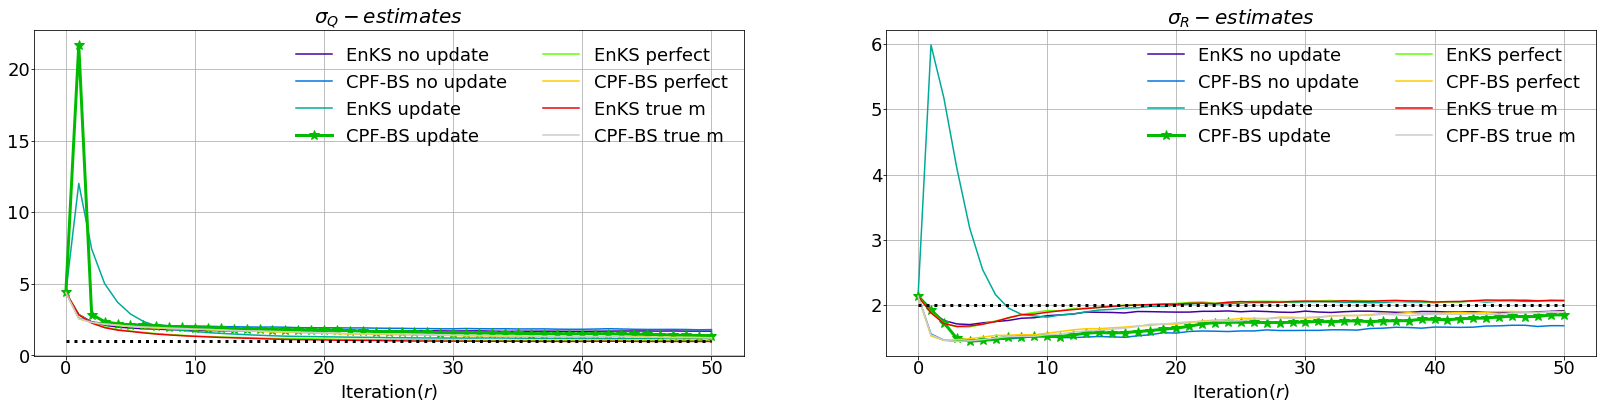

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


--> The npSEM algorithms ('EnKS update' and 'CPF-BS update') provide estimates close to the ones obtained with 'EnKS perfect' and 'CPF-BS perfect' and the two SEM algorithms using the true L63 model. With dt_model = 8, the nonlinearity of the true dynamic is low. The 'CPF-BS update' provides similar results as the 'EnKS update' in estimating variances of noises. Increase dt_model to compare the performance of the two approaches on high nonlinear SSMs!
##############################################################################################################################################################################################
2. Corrected catalog from in the npSEM algorithm ('CPF-BS update')


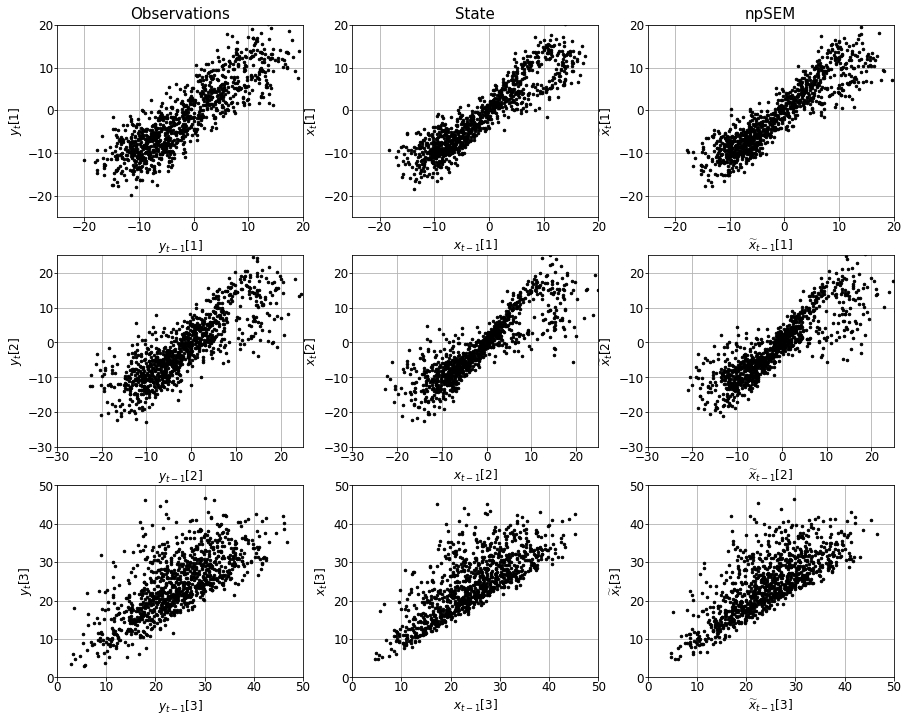

--> The npSEM algorithm probably filters the observation errors from the observations, the adjusted catalog from the last iteration of the algorithm is close to the true.
##############################################################################################################################################################################################
3. State reconstruction in the npSEM algorithm ('CPF-BS update')


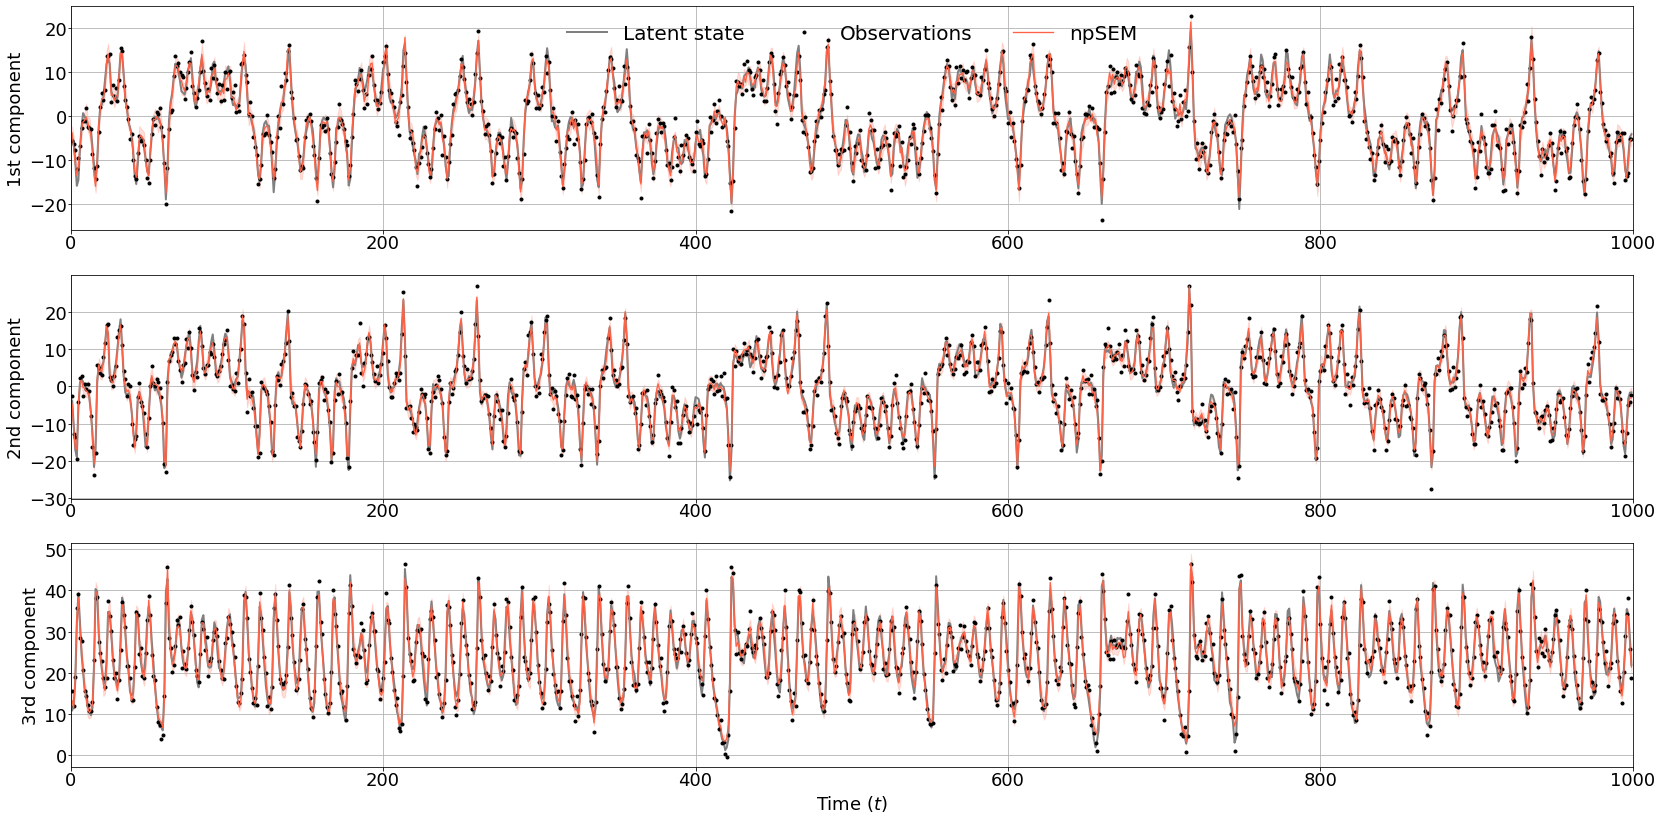

RMSEs between the true state and the mean of the smoothing distribution derived from the SEM and npSEM algorithms:
+  EnKS no update 1.1188 EnKS update 1.0856 EnKS perfect 0.9881 EnKS true m 0.9379
+  CPF-BS no update 1.2813 CPF-BS update 1.1718 CPF-BS perfect 1.1137 CPF-BS true m 1.0539
--> The npSEM algorithm ('CPF-BS update') is able to recover the true trajectory given only the noisy observations.


In [12]:
# PLOTTING RESULTS
#%% Plot of time series
def CV95(Xs,X):
    T = len(X)
    CIlowXs = np.percentile(Xs, 2.5, axis= 0)
    CIupXs = np.percentile(Xs, 97.5, axis= 0)
    cov_prob1= np.array(np.where(CIlowXs < X))
    cov_prob2= np.array(np.where(X< CIupXs))
    cov_prob= len(np.intersect1d(cov_prob1,cov_prob2))/T*100
    return cov_prob, CIlowXs, CIupXs

mylabels = ["EnKS no update", "CPF-BS no update", "EnKS update", "CPF-BS update", "EnKS perfect", "CPF-BS perfect", "EnKS true m", "CPF-BS true m"]
all_colors = cm.get_cmap('nipy_spectral',len(mylabels)+1)
mycolors = all_colors(range(1,len(mylabels)+1))

print('1. Parameter estimation in SEM and npSEM algorithms (horizontal black lines materialize the true values)')
FS = 20; FS1 =18; LW= 3; MS = 10; LP = -0.1
plt.rcParams['figure.figsize'] = (28,6)
plt.rcParams['xtick.major.pad']='0'
plt.rcParams['ytick.major.pad']='0'
plt.rc('xtick', labelsize= FS1) 
plt.rc('ytick', labelsize= FS1)
plt.figure()
plt.subplot(121)
plt.plot(np.sqrt(np.trace(Q_SEM_ENKS)/dx),color = mycolors[0],label = mylabels[0])
plt.plot(np.sqrt(np.trace(Q_SEM_CPF)/dx),color = mycolors[1],label = mylabels[1])
plt.plot(np.sqrt(np.trace(Q_npSEM_ENKS)/dx),color = mycolors[2],label = mylabels[2])
plt.plot(np.sqrt(np.trace(Q_npSEM_CPF)/dx),'*-',linewidth =LW,markersize=MS,color = mycolors[3],label = mylabels[3])
plt.plot(np.sqrt(np.trace(Q_SEM_ENKS_perfect)/dx),color = mycolors[4],label = mylabels[4])
plt.plot(np.sqrt(np.trace(Q_SEM_CPF_perfect)/dx),color = mycolors[5],label = mylabels[5])
plt.plot(np.sqrt(np.trace(Q_SEM_ENKS_m)/dx),color = mycolors[6],label = mylabels[6])
plt.plot(np.sqrt(np.trace(Q_SEM_CPF_m)/dx),color = mycolors[7],label = mylabels[7])
plt.plot((0,N_iter),(np.sqrt(np.trace(Q_true)/dx),np.sqrt(np.trace(Q_true)/dx)),':',linewidth =LW,color = 'k')
plt.legend(frameon =False, ncol=2, fontsize =FS1)                      
plt.xlabel('Iteration($r$)', fontsize =FS1)   
plt.title(r'$\sigma_Q-estimates$', fontsize =FS)   
# plt.xlim([-5,ilim])
plt.grid()

plt.subplot(122)
plt.plot(np.sqrt(np.trace(R_SEM_ENKS)/dy),color = mycolors[0],label = mylabels[0])
plt.plot(np.sqrt(np.trace(R_SEM_CPF)/dy),color = mycolors[1],label = mylabels[1])
plt.plot(np.sqrt(np.trace(R_npSEM_ENKS)/dy),color = mycolors[2],label = mylabels[2])
plt.plot(np.sqrt(np.trace(R_npSEM_CPF)/dy),'*-',linewidth =LW,markersize=MS,color = mycolors[3],label = mylabels[3])
plt.plot(np.sqrt(np.trace(R_SEM_ENKS_perfect)/dy),color = mycolors[4],label = mylabels[4])
plt.plot(np.sqrt(np.trace(R_SEM_CPF_perfect)/dy),color = mycolors[5],label = mylabels[5])
plt.plot(np.sqrt(np.trace(R_SEM_ENKS_m)/dy),color = mycolors[6],label = mylabels[6])
plt.plot(np.sqrt(np.trace(R_SEM_CPF_m)/dy),color = mycolors[7],label = mylabels[7])
plt.plot((0,N_iter),(np.sqrt(np.trace(R_true)/dy),np.sqrt(np.trace(R_true)/dy)),':',linewidth =LW,color = 'k')
plt.legend(frameon =False, ncol=2, fontsize =FS1)                      
plt.xlabel('Iteration($r$)', fontsize =FS1)   
plt.title(r'$\sigma_R-estimates$', fontsize =FS)   
# plt.xlim([-5,ilim])
plt.grid()
plt.show()
print('--> The npSEM algorithms (\'EnKS update\' and \'CPF-BS update\') provide estimates close to the ones obtained with \'EnKS perfect\' and \'CPF-BS perfect\' \
and the two SEM algorithms using the true L63 model. With dt_model = 8, the nonlinearity of the true dynamic is low. The \'CPF-BS update\' \
provides similar results as the \'EnKS update\' in estimating variances of noises. Increase dt_model to compare the performance of the two approaches on high nonlinear SSMs!')
print('##############################################################################################################################################################################################')                      
print('2. Corrected catalog from in the npSEM algorithm (\'CPF-BS update\')')
X_tr = X_train.values; Y_tr = Y_train.values;  X_te = X_test.values;  X_up = Xs_npSEM_CPF[:,0,:,-1] 

###########################PLOT HERE###########################
# state and observations (when available)

FS = 15; FS1 =12; LW= 3; MS = 5; LP = -0.1
plt.rcParams['figure.figsize'] = (15,12)
plt.rcParams['xtick.major.pad']='0'
plt.rcParams['ytick.major.pad']='0'
plt.rc('xtick', labelsize= FS1) 
plt.rc('ytick', labelsize= FS1)
plt.figure()  
for i in range(3):
    if i == 0:
        xmin, xmax, ymin, ymax =  -25, 20, -25, 20
    if i == 1:
        xmin, xmax, ymin, ymax =  -30, 25, -30, 25
    if i == 2:
        xmin, xmax, ymin, ymax =  0, 50, 0, 50    
    state_X = np.sort(X_te[i,:].squeeze())
    ind_sort_X = np.argsort(X_te[i,:].squeeze())
    plt.subplot(3,3,3*i+1)
    plt.plot(Y_tr[i,:-1],Y_tr[i,1:], 'k.',markersize= MS)
#     plt.legend(fontsize = FS1, ncol =2,frameon=False,loc ='best')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('$y_{t-1}$['+str(i+1)+']', fontsize=FS1)
    plt.ylabel('$y_{t}$['+str(i+1)+']', fontsize=FS1)
    plt.grid()
    if i == 0:
        plt.title('Observations', fontsize = FS)
    plt.subplot(3,3,3*i+2)
    plt.plot(X_tr[i,:-1],X_tr[i,1:], 'k.',markersize= MS)
    plt.legend(fontsize = FS1, ncol =2,frameon=False,loc ='best')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('$x_{t-1}$['+str(i+1)+']', fontsize=FS1)
    plt.ylabel('$x_{t}$['+str(i+1)+']', fontsize=FS1)
    plt.grid()
    if  i== 0:
        plt.title('State', fontsize = FS)
    plt.subplot(3,3,3*i+3)
    plt.plot(X_up[i,:-1],X_up[i,1:], 'k.',markersize= MS)
#     plt.legend(fontsize = FS1, ncol =2,frameon=False,loc ='best')
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel(r'$\widetilde {x}_{t-1}$['+str(i+1)+']', fontsize=FS1)
    plt.ylabel(r'$\widetilde {x}_{t}$['+str(i+1)+']', fontsize=FS1)
    plt.grid()
    if i == 0:
        plt.title('npSEM', fontsize = FS)
plt.show()
print('--> The npSEM algorithm probably filters the observation errors from the observations, the adjusted catalog from the last iteration of the algorithm is close to the true.')
print('##############################################################################################################################################################################################')                      
print('3. State reconstruction in the npSEM algorithm (\'CPF-BS update\')')   
ylb = ['1st component','2nd component','3rd component']
num_iter_taken = 10;  num_iter_taken_EnKS = 10
X = X_test.values; Y = Y_test.values
Xs_CPF = Xs_test_npSEM_CPF#Xs_npSEM_CPFBS
time = np.arange(T)
FS = 20; FS1 =18; LW= 2; MS = 6; LP = -0.1
plt.rcParams['figure.figsize'] = (28,14)
plt.rcParams['xtick.major.pad']='0'
plt.rcParams['ytick.major.pad']='0'
plt.rc('xtick', labelsize= FS1) 
plt.rc('ytick', labelsize= FS1)
plt.figure()
for i in range(3):
    var = i
    XsBS = np.squeeze(Xs_CPF[var,:,:,-num_iter_taken:]).transpose((2,0,1))
    XsBS = XsBS.reshape(Ns*num_iter_taken,T)
    XsBS_mean = XsBS.mean(axis=0); 
    cov_prob, CIlowBS, CIupBS = CV95(XsBS[:,1:] ,X[var,1:])      

    plt.subplot(3,1,i+1)
    plt.fill_between(time[1:], CIlowBS,CIupBS, color="tomato", alpha=0.2)#,sig2_Qha =0.3 )
    plt.plot(time[1:],X[var,1:], '-', color='grey', linewidth =LW, label = 'Latent state')
    plt.plot(time[1:],Y[var,:], '.k', markersize = MS, label ='Observations')
    plt.plot(time[1:],XsBS_mean[1:],'tomato',linewidth =LW*2/3, label ='npSEM')
    if i==2:
        plt.xlabel('Time ($t$)', fontsize = FS1)
    plt.ylabel(ylb[i], fontsize =FS1)
    plt.xlim([0,1000])
    if i ==0: 
        plt.legend(fontsize = FS,ncol=4,frameon=False,loc ='best')
    plt.grid()
plt.show()

# Compute the reconstruction errors
RMSE_SEM_ENKS_m = RMSE(X_test.values[:,:]-Xs_test_SEM_ENKS_m[...,-num_iter_taken_EnKS:].mean(3).mean(1)).round(4)
RMSE_SEM_ENKS  = RMSE(X_test.values[:,:]-Xs_test_SEM_ENKS[...,-num_iter_taken_EnKS:].mean(3).mean(1)).round(4)
RMSE_SEM_ENKS_perfect = RMSE(X_test.values[:,:]-Xs_test_SEM_ENKS_perfect[...,-num_iter_taken_EnKS:].mean(3).mean(1)).round(4)
RMSE_npSEM_ENKS  = RMSE(X_test.values[:,:]-Xs_test_npSEM_ENKS[...,-num_iter_taken_EnKS:].mean(3).mean(1)).round(4)
RMSE_SEM_CPFBS_m  = RMSE(X_test.values[:,:]-Xs_test_SEM_CPF_m[...,-num_iter_taken:].mean(3).mean(1)).round(4)
RMSE_SEM_CPFBS = RMSE(X_test.values[:,:]-Xs_test_SEM_CPF[...,-num_iter_taken:].mean(3).mean(1)).round(4)
RMSE_SEM_CPFBS_perfect = RMSE(X_test.values[:,:]-Xs_test_SEM_CPF_perfect[...,-num_iter_taken:].mean(3).mean(1)).round(4)
RMSE_npSEM_CPFBS = RMSE(X_test.values[:,:]-Xs_test_npSEM_CPF[...,-num_iter_taken:].mean(3).mean(1)).round(4)
print('RMSEs between the true state and the mean of the smoothing distribution derived from the SEM and npSEM algorithms:')
print('+ ', mylabels[0], RMSE_SEM_ENKS, mylabels[2], RMSE_npSEM_ENKS, mylabels[4], RMSE_SEM_ENKS_perfect, mylabels[6], RMSE_SEM_ENKS_m)
print('+ ', mylabels[1], RMSE_SEM_CPFBS, mylabels[3], RMSE_npSEM_CPFBS, mylabels[5], RMSE_SEM_CPFBS_perfect, mylabels[7], RMSE_SEM_CPFBS_m)
print('--> The npSEM algorithm (\'CPF-BS update\') is able to recover the true trajectory given only the noisy observations.')

** The above results are derived after only 50 iterations of the SEM and npSEM algorithms. Run more to see how the npSEM algorithm obtains better results :)!